In [1]:
# connect to driver
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
! unzip "/content/drive/MyDrive/outsource/Bone Fracture/Bone Fracture Detection.zip" -d "/content/drive/MyDrive/outsource/Bone Fracture/"

# 1. Import thư viện cần thiết

In [2]:
# install ultralytics
%%capture
!pip install ultralytics

In [3]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import torch
import numpy as np

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Hàm đọc nhãn từ file YOLOv8 format
def read_labels(label_path):
    boxes = []
    with open(label_path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            cx, cy, w, h = map(float, parts[1:])
            boxes.append((class_id, cx, cy, w, h))
            print(boxes)
    return boxes

# Hàm vẽ bounding box lên ảnh
def draw_boxes(image, boxes, image_size):
    h, w = image_size
    for box in boxes:
        class_id, cx, cy, bw, bh = box
        # Chuyển đổi từ tọa độ tương đối sang tọa độ tuyệt đối
        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)
        # Vẽ bounding box
        color = (0, 255, 0)  # Màu xanh lá
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    return image

# Hàm đọc nhãn từ file YOLOv8 format (bounding boxes)
def read_labels(label_path):
    labels = []
    with open(label_path, 'r') as file:
        for line in file.readlines():
            parts = line.strip().split()
            class_id = int(parts[0])
            bbox = list(map(float, parts[1:]))
            labels.append((class_id, bbox))
    return labels

# Hàm vẽ bounding box và tọa độ lên ảnh
def draw_bounding_boxes_with_coords(image, labels, color=(0, 255, 0), label_type="True"):
    h, w = image.shape[:2]
    for label in labels:
        class_id, bbox = label
        # Chuyển đổi từ tọa độ tương đối sang tọa độ tuyệt đối
        cx, cy, bw, bh = bbox
        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)

        # Vẽ bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

        # Hiển thị class và tọa độ bounding box
        label_text = f'{label_type} {class_id}: ({x1}, {y1}), ({x2}, {y2})'
        cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return image

# 2. Load dữ liệu training

In [ ]:
# Đường dẫn tới thư mục chứa ảnh và nhãn
image_dir = '/content/drive/MyDrive/outsource/Bone Fracture/train/images'
label_dir = '/content/drive/MyDrive/outsource/Bone Fracture/train/labels'

# Lấy danh sách các file ảnh
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Chọn 10 ảnh ngẫu nhiên
sample_images = random.sample(image_files, 10)

# Vẽ và hiển thị các ảnh
for image_file in sample_images:
    # Đọc ảnh
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB để hiển thị với matplotlib

    # Đọc file nhãn
    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(label_dir, label_file)

    if os.path.exists(label_path):
        boxes = read_labels(label_path)
        image = draw_boxes(image, boxes, image.shape[:2])

    # Hiển thị ảnh với bounding box
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis('off')  # Tắt trục tọa độ
    plt.show()

# 3. Training mô hình từ mô hình yolov8n

In [ ]:
%cd /content/drive/MyDrive/outsource/Bone Fracture/
# Khởi tạo mô hình YOLOv8
model = YOLO('yolov8n.pt')
# Huấn luyện mô hình với dữ liệu bounding box
model.train(
    data='/content/drive/MyDrive/outsource/Bone Fracture/data.yaml',  # Đường dẫn tới file cấu hình dữ liệu
    epochs=100,        # Số epoch huấn luyện
    imgsz=640,         # Kích thước ảnh
    batch=16,          # Batch size
    name='yolov8_detection',
    device=0 #GPU
)

/content/drive/.shortcut-targets-by-id/1oRo6v0CIuNQ5z_ABUrID87vek1GrC5Zl/outsource/Bone Fracture
Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/drive/MyDrive/outsource/Bone Fracture/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=yolov8_detection6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=Fa

train: Scanning /content/drive/.shortcut-targets-by-id/1oRo6v0CIuNQ5z_ABUrID87vek1GrC5Zl/outsource/Bone Fracture/train/labels... 2208 images, 12 backgrounds, 0 corrupt: 100%|██████████| 2208/2208 [08:31<00:00,  4.32it/s]


train: New cache created: /content/drive/.shortcut-targets-by-id/1oRo6v0CIuNQ5z_ABUrID87vek1GrC5Zl/outsource/Bone Fracture/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/drive/.shortcut-targets-by-id/1oRo6v0CIuNQ5z_ABUrID87vek1GrC5Zl/outsource/Bone Fracture/valid/labels.cache... 209 images, 0 backgrounds, 0 corrupt: 100%|██████████| 209/209 [00:00<?, ?it/s]

val: WARNING ⚠️ /content/drive/.shortcut-targets-by-id/1oRo6v0CIuNQ5z_ABUrID87vek1GrC5Zl/outsource/Bone Fracture/valid/images/normal-59-_jpg.rf.f29f3cbaff97e63c48c2e45a5dcc09ea.jpg: 1 duplicate labels removed


Plotting labels to runs/detect/yolov8_detection6/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8_detection6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.36G     0.5688      1.721      1.208         48        640: 100%|██████████| 138/138 [00:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]

                   all        209        221      0.857      0.483      0.416      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.32G      0.488      1.149      1.141         42        640: 100%|██████████| 138/138 [00:55<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.91it/s]


                   all        209        221      0.695      0.384      0.204     0.0628

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.32G     0.4586     0.9837      1.114         47        640: 100%|██████████| 138/138 [00:56<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


                   all        209        221      0.838       0.45      0.413      0.336

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.32G     0.4722      0.955      1.123         47        640: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]

                   all        209        221      0.769       0.37      0.307      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.32G     0.4285     0.8586      1.093         38        640: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.94it/s]


                   all        209        221      0.292      0.383      0.278      0.204

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.32G     0.4147     0.8335        1.1         39        640: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.06it/s]


                   all        209        221      0.441       0.48      0.422      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.32G     0.3838     0.7883      1.076         45        640: 100%|██████████| 138/138 [00:56<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.77it/s]

                   all        209        221      0.866      0.483      0.463      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.32G     0.3901     0.7741      1.082         39        640: 100%|██████████| 138/138 [00:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.43it/s]

                   all        209        221      0.453       0.51      0.454      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.32G     0.3669      0.778      1.071         33        640: 100%|██████████| 138/138 [00:55<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.35it/s]

                   all        209        221      0.473      0.543      0.457      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.32G     0.3506     0.7212      1.058         44        640: 100%|██████████| 138/138 [00:56<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.85it/s]

                   all        209        221      0.431      0.553      0.467      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.32G     0.3494     0.7226      1.046         36        640: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

                   all        209        221      0.444      0.478      0.465      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.32G     0.3518     0.7221      1.054         36        640: 100%|██████████| 138/138 [00:56<00:00,  2.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]

                   all        209        221      0.802      0.407      0.406       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.32G     0.3348     0.6857      1.045         42        640: 100%|██████████| 138/138 [00:54<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]

                   all        209        221      0.429      0.557      0.472      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.32G     0.3467     0.6896      1.057         45        640: 100%|██████████| 138/138 [00:55<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.23it/s]

                   all        209        221      0.486      0.485      0.469      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.32G     0.3324     0.6683      1.053         47        640: 100%|██████████| 138/138 [00:57<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]


                   all        209        221      0.468      0.543      0.496      0.442

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.32G     0.3255     0.6696      1.034         44        640: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]


                   all        209        221      0.558      0.583      0.531      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.32G     0.3368     0.6669      1.056         37        640: 100%|██████████| 138/138 [00:57<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

                   all        209        221      0.901      0.401      0.486      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.32G     0.3246     0.6535      1.044         46        640: 100%|██████████| 138/138 [00:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]

                   all        209        221      0.461      0.623      0.524      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.32G      0.314     0.6353      1.044         33        640: 100%|██████████| 138/138 [00:54<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]

                   all        209        221      0.456      0.563      0.521      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.32G     0.3245     0.6297      1.043         51        640: 100%|██████████| 138/138 [00:58<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.00it/s]

                   all        209        221      0.486      0.613      0.531       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.32G     0.3094      0.617      1.041         41        640: 100%|██████████| 138/138 [01:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]

                   all        209        221      0.603      0.583      0.564      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.32G     0.3224     0.6236      1.047         37        640: 100%|██████████| 138/138 [00:57<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]

                   all        209        221      0.511      0.577      0.533      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.32G     0.3156     0.6171      1.041         32        640: 100%|██████████| 138/138 [00:54<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.95it/s]

                   all        209        221      0.487      0.622      0.534      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.32G     0.3219     0.6273      1.042         39        640: 100%|██████████| 138/138 [00:56<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]

                   all        209        221      0.536      0.643      0.549      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.32G      0.307     0.6147      1.033         44        640: 100%|██████████| 138/138 [00:57<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]

                   all        209        221      0.537       0.61      0.562      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.32G     0.2988     0.5988       1.02         40        640: 100%|██████████| 138/138 [00:58<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.81it/s]

                   all        209        221      0.532      0.626      0.554      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.32G     0.2996     0.5975      1.035         36        640: 100%|██████████| 138/138 [00:54<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]

                   all        209        221      0.504      0.657       0.59      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.32G     0.3016     0.6223      1.022         49        640: 100%|██████████| 138/138 [00:55<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

                   all        209        221      0.501       0.59      0.542      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.32G     0.3156     0.6022      1.031         40        640: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        209        221      0.529      0.615      0.583      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.32G     0.3194      0.607      1.041         40        640: 100%|██████████| 138/138 [00:58<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.72it/s]

                   all        209        221      0.537      0.602       0.53      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.32G     0.2998     0.5994       1.03         35        640: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.37it/s]


                   all        209        221      0.587      0.553      0.538      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.32G     0.2857     0.5669      1.014         41        640: 100%|██████████| 138/138 [00:58<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.51it/s]

                   all        209        221      0.566       0.61      0.582      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.32G     0.3063     0.5923      1.019         39        640: 100%|██████████| 138/138 [00:56<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]

                   all        209        221      0.636      0.617      0.602       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.32G     0.3014     0.5682      1.021         51        640: 100%|██████████| 138/138 [00:54<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]

                   all        209        221      0.622      0.607       0.61       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.32G     0.2829     0.5441      1.011         45        640: 100%|██████████| 138/138 [00:54<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.43it/s]

                   all        209        221      0.533      0.633      0.551      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.32G     0.2994     0.5719      1.028         45        640: 100%|██████████| 138/138 [00:58<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.31it/s]

                   all        209        221      0.574       0.67      0.608      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.32G     0.2808     0.5484      1.016         37        640: 100%|██████████| 138/138 [00:59<00:00,  2.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

                   all        209        221      0.667      0.576      0.586      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.32G     0.3001     0.5571      1.025         46        640: 100%|██████████| 138/138 [00:57<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.66it/s]

                   all        209        221        0.6      0.629      0.605      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.32G     0.2911     0.5473      1.027         43        640: 100%|██████████| 138/138 [00:55<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]

                   all        209        221      0.607      0.666      0.622      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.32G     0.2791     0.5304      1.017         39        640: 100%|██████████| 138/138 [00:56<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.81it/s]

                   all        209        221      0.635      0.626      0.601      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.32G     0.2746     0.5324      1.012         45        640: 100%|██████████| 138/138 [00:57<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.12it/s]

                   all        209        221      0.684      0.636      0.624      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.32G     0.2892     0.5544      1.017         30        640: 100%|██████████| 138/138 [01:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.07it/s]

                   all        209        221      0.621      0.653      0.641      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.32G     0.2986     0.5419      1.023         46        640: 100%|██████████| 138/138 [00:57<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        209        221      0.584      0.643        0.6      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.32G     0.2948     0.5497      1.021         42        640: 100%|██████████| 138/138 [00:56<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

                   all        209        221       0.72      0.617        0.6      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.32G      0.275      0.522      1.012         36        640: 100%|██████████| 138/138 [00:54<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]

                   all        209        221       0.64      0.621      0.626      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.32G     0.2831      0.521      1.018         42        640: 100%|██████████| 138/138 [00:57<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.77it/s]

                   all        209        221      0.609      0.673      0.644      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.32G     0.2937     0.5216      1.026         37        640: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.86it/s]

                   all        209        221      0.671      0.666      0.639      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.32G     0.2858     0.5113      1.015         46        640: 100%|██████████| 138/138 [00:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


                   all        209        221      0.604      0.646      0.613      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.32G     0.2862     0.5319      1.018         39        640: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.67it/s]

                   all        209        221      0.635      0.679      0.641      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.32G     0.2855     0.5118      1.018         41        640: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.03it/s]

                   all        209        221       0.71      0.616      0.637        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.32G     0.2713     0.5087      1.005         30        640: 100%|██████████| 138/138 [00:57<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

                   all        209        221      0.638      0.663       0.63      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.32G     0.2799     0.5138      1.018         39        640: 100%|██████████| 138/138 [00:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

                   all        209        221      0.677      0.676      0.662      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.32G     0.2785     0.5001       1.01         41        640: 100%|██████████| 138/138 [00:57<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        209        221      0.682      0.683      0.652      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.32G     0.2795     0.5063      1.015         41        640: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.18it/s]

                   all        209        221      0.718       0.62       0.64      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.32G     0.2833     0.4945       1.01         34        640: 100%|██████████| 138/138 [01:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        209        221      0.832       0.65      0.692      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.32G      0.271     0.4885       1.01         46        640: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

                   all        209        221      0.654      0.643      0.629      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.32G     0.2652     0.4791      1.001         39        640: 100%|██████████| 138/138 [00:57<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.84it/s]

                   all        209        221      0.672      0.649      0.656      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.32G      0.273     0.4834      1.011         52        640: 100%|██████████| 138/138 [00:54<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.79it/s]

                   all        209        221      0.705      0.633      0.634       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.32G     0.2727     0.4912      1.004         50        640: 100%|██████████| 138/138 [00:57<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.73it/s]

                   all        209        221      0.743      0.649      0.661      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.32G     0.2697     0.4682      1.001         44        640: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.65it/s]

                   all        209        221      0.638      0.653      0.643       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.32G     0.2725     0.4644      1.001         47        640: 100%|██████████| 138/138 [00:59<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.62it/s]

                   all        209        221      0.733      0.693      0.679      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.32G     0.2741     0.4686      1.002         43        640: 100%|██████████| 138/138 [01:00<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.63it/s]

                   all        209        221      0.705       0.65      0.643       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.32G     0.2779     0.4699      1.003         40        640: 100%|██████████| 138/138 [00:58<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.52it/s]

                   all        209        221      0.716      0.633       0.64      0.508



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.32G      0.261     0.4596     0.9946         44        640: 100%|██████████| 138/138 [00:55<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]

                   all        209        221      0.687      0.658       0.65      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.32G     0.2633     0.4526      1.002         43        640: 100%|██████████| 138/138 [00:54<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.41it/s]

                   all        209        221      0.683      0.664      0.636      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.32G     0.2615     0.4542     0.9979         43        640: 100%|██████████| 138/138 [00:58<00:00,  2.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.70it/s]

                   all        209        221      0.726       0.63      0.653      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.32G     0.2516     0.4333     0.9947         41        640: 100%|██████████| 138/138 [01:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        209        221      0.826       0.63      0.663      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.32G     0.2554     0.4517     0.9967         43        640: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]

                   all        209        221      0.735      0.637      0.653      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.32G     0.2503     0.4243      0.992         38        640: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.61it/s]

                   all        209        221       0.68      0.669      0.648      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.32G     0.2602     0.4453     0.9919         37        640: 100%|██████████| 138/138 [00:57<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]

                   all        209        221       0.82      0.669      0.703      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.32G     0.2632     0.4449      1.002         36        640: 100%|██████████| 138/138 [00:55<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.76it/s]

                   all        209        221      0.854      0.616      0.658      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.32G     0.2554     0.4301     0.9938         46        640: 100%|██████████| 138/138 [00:57<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.83it/s]

                   all        209        221       0.72      0.673      0.673      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.32G     0.2518      0.429     0.9954         40        640: 100%|██████████| 138/138 [01:00<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.09it/s]

                   all        209        221      0.725      0.674       0.69      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.32G     0.2562     0.4213     0.9898         45        640: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.96it/s]

                   all        209        221      0.851      0.673      0.688      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.32G     0.2503     0.4078     0.9823         36        640: 100%|██████████| 138/138 [00:57<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.13it/s]

                   all        209        221      0.777      0.675      0.699      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.32G     0.2486     0.4305     0.9849         40        640: 100%|██████████| 138/138 [00:56<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.45it/s]

                   all        209        221      0.775      0.666      0.685      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.32G     0.2622      0.424     0.9909         47        640: 100%|██████████| 138/138 [00:55<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.21it/s]

                   all        209        221      0.685       0.69       0.66      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.32G     0.2503     0.4143     0.9904         45        640: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.05it/s]


                   all        209        221      0.754      0.681      0.706      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.32G     0.2378     0.4118     0.9854         46        640: 100%|██████████| 138/138 [00:58<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        209        221      0.759      0.693       0.69      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.32G     0.2392     0.3958     0.9841         45        640: 100%|██████████| 138/138 [00:59<00:00,  2.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.27it/s]

                   all        209        221      0.759      0.683      0.686       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.32G     0.2435     0.4005     0.9907         38        640: 100%|██████████| 138/138 [00:58<00:00,  2.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]

                   all        209        221      0.748       0.65       0.64        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.32G     0.2502     0.3979     0.9837         38        640: 100%|██████████| 138/138 [00:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.71it/s]

                   all        209        221      0.647       0.73      0.675      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.32G     0.2403     0.3946     0.9906         38        640: 100%|██████████| 138/138 [00:57<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.58it/s]

                   all        209        221      0.687      0.723      0.673      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.32G     0.2542     0.4107     0.9856         39        640: 100%|██████████| 138/138 [01:00<00:00,  2.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.98it/s]

                   all        209        221      0.731      0.683      0.689      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.32G     0.2405     0.3928     0.9782         35        640: 100%|██████████| 138/138 [00:59<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  3.03it/s]

                   all        209        221      0.741      0.678      0.683       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.32G     0.2331     0.3887     0.9742         36        640: 100%|██████████| 138/138 [00:59<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.89it/s]

                   all        209        221      0.733       0.67      0.673      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.32G     0.2246     0.3823     0.9736         40        640: 100%|██████████| 138/138 [00:57<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.50it/s]

                   all        209        221      0.707      0.713      0.677      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.32G      0.227     0.3937     0.9679         35        640: 100%|██████████| 138/138 [00:55<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.68it/s]

                   all        209        221      0.797      0.666      0.699      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.32G     0.2256     0.3702     0.9702         42        640: 100%|██████████| 138/138 [00:55<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.75it/s]

                   all        209        221      0.759      0.632      0.664      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.32G     0.2388     0.3685     0.9827         32        640: 100%|██████████| 138/138 [00:57<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]

                   all        209        221       0.72      0.733      0.694      0.534


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.32G     0.3607      0.397      1.058         18        640: 100%|██████████| 138/138 [01:00<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.93it/s]

                   all        209        221      0.785      0.696       0.69      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.32G     0.3535     0.3114       1.06         16        640: 100%|██████████| 138/138 [00:55<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]

                   all        209        221      0.716       0.72      0.713      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.32G     0.3317      0.303      1.038         17        640: 100%|██████████| 138/138 [00:52<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  2.06it/s]

                   all        209        221      0.721        0.7      0.677      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.32G     0.3357     0.3055      1.029         16        640: 100%|██████████| 138/138 [00:56<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.90it/s]

                   all        209        221      0.734        0.7      0.692       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.32G     0.3311     0.2834      1.037         16        640: 100%|██████████| 138/138 [00:57<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.42it/s]

                   all        209        221       0.73      0.687      0.691      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.32G     0.3348     0.2921      1.033         17        640: 100%|██████████| 138/138 [00:52<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.99it/s]

                   all        209        221      0.737      0.713      0.693      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.32G     0.3299     0.2944       1.03         16        640: 100%|██████████| 138/138 [00:55<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.99it/s]

                   all        209        221      0.759      0.692      0.686      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.32G     0.3191     0.2767      1.026         16        640: 100%|██████████| 138/138 [00:56<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        209        221      0.763      0.705      0.706      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.32G     0.3185     0.2823      1.017         17        640: 100%|██████████| 138/138 [00:53<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:04<00:00,  1.70it/s]

                   all        209        221      0.783      0.701      0.708      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.32G     0.3139     0.2779      1.032         16        640: 100%|██████████| 138/138 [00:54<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:02<00:00,  2.84it/s]

                   all        209        221      0.775      0.684      0.691       0.52



100 epochs completed in 1.721 hours.
Optimizer stripped from runs/detect/yolov8_detection6/weights/last.pt, 6.3MB
Optimizer stripped from runs/detect/yolov8_detection6/weights/best.pt, 6.3MB

Validating runs/detect/yolov8_detection6/weights/best.pt...
Ultralytics YOLOv8.2.79 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:08<00:00,  1.16s/it]


                   all        209        221       0.82      0.669      0.704      0.533
              Fracture         63         75      0.777      0.371      0.458      0.143
          Not_Fracture        146        146      0.862      0.966       0.95      0.924
Speed: 0.6ms preprocess, 3.4ms inference, 0.0ms loss, 7.8ms postprocess per image
Results saved to runs/detect/yolov8_detection6


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dfc437a68f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

# 4. Đánh giá mô hình

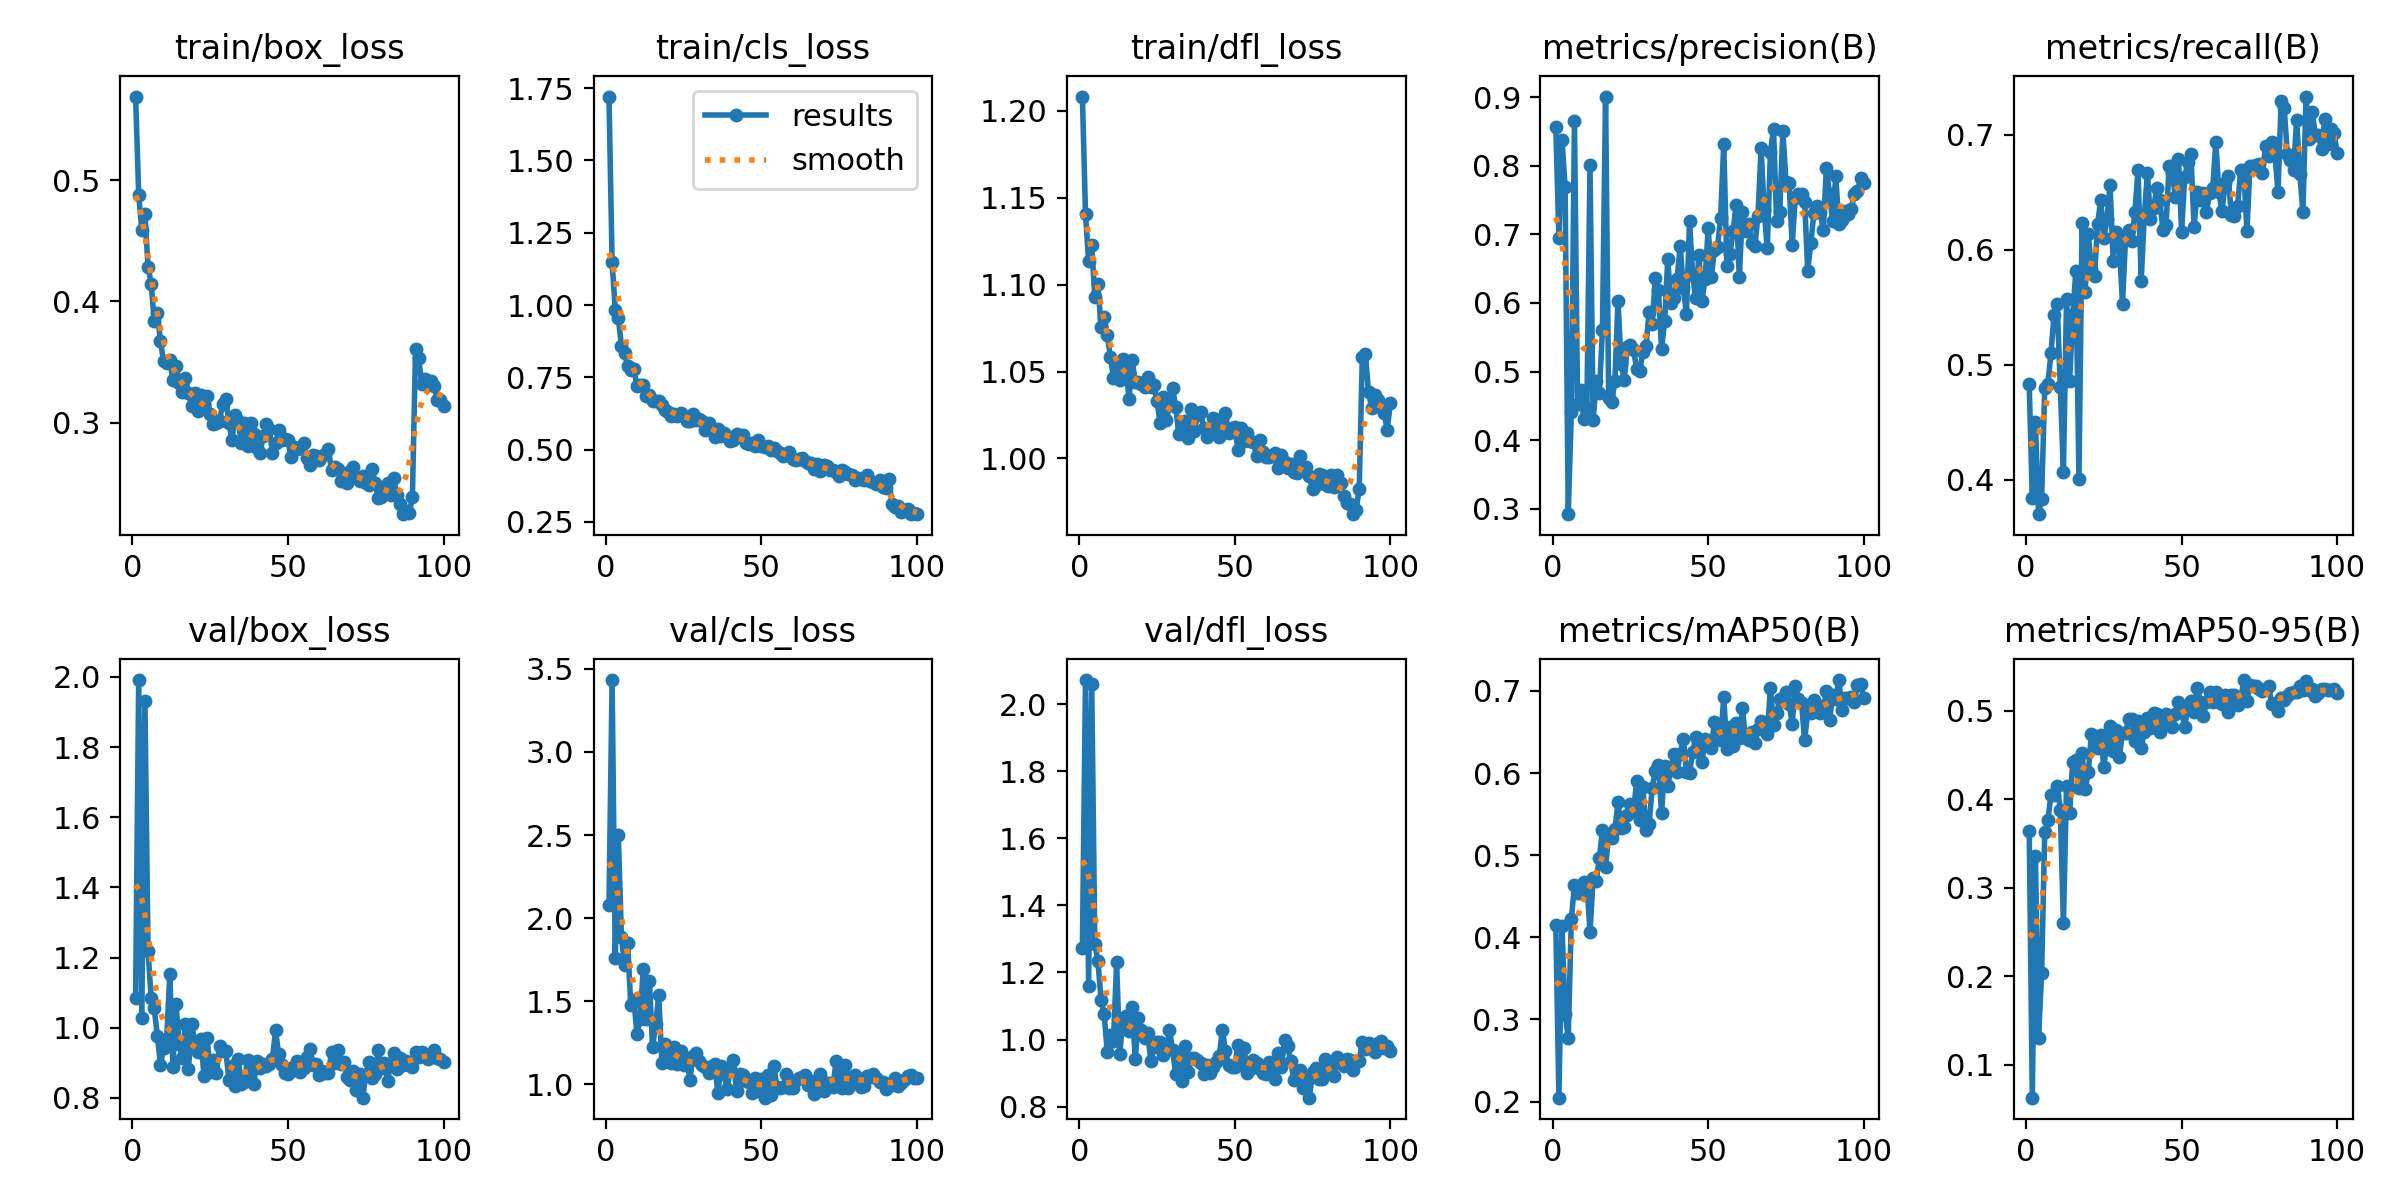

In [ ]:
from IPython.display import Image
Image(filename=f'/content/drive/MyDrive/outsource/Bone Fracture/runs/detect/yolov8_detection3/results.png', width=800)


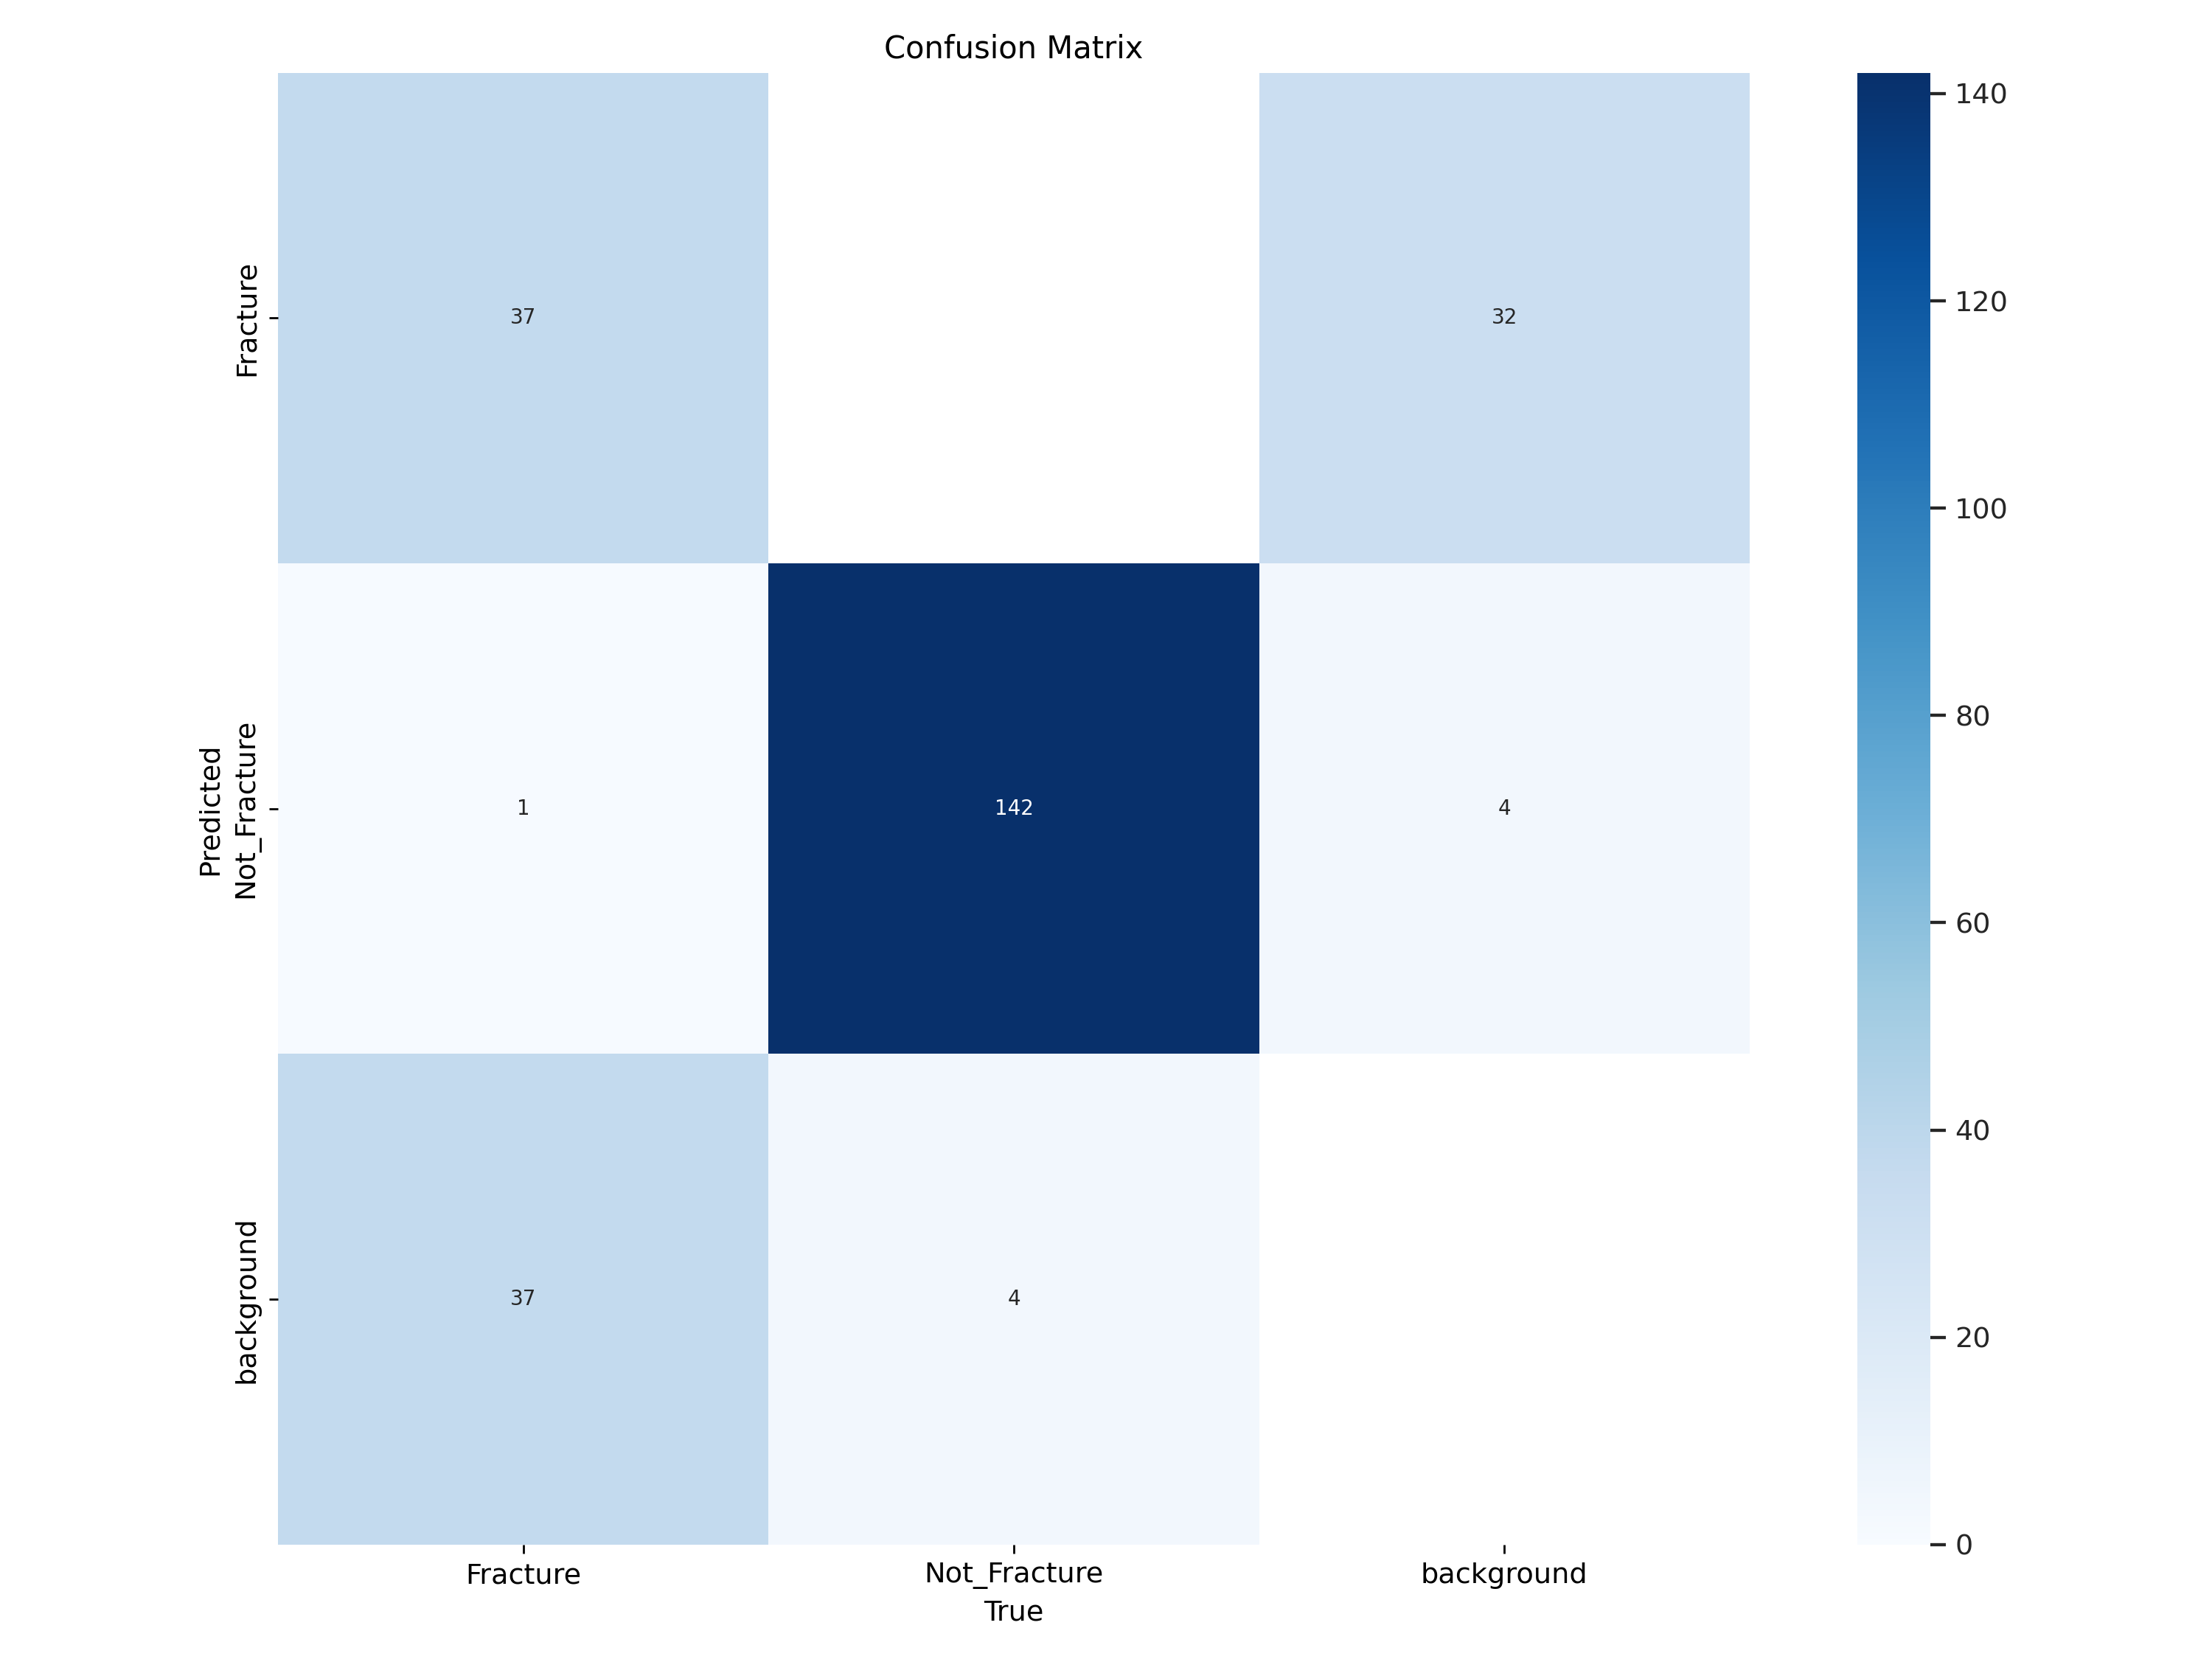

In [ ]:
Image(filename=f'/content/drive/MyDrive/outsource/Bone Fracture/runs/detect/yolov8_detection3/confusion_matrix.png', width=800)


# 5. Quan sát ảnh predict với 10 ảnh ngẫu nhiên từ tập test


image 1/1 /content/drive/MyDrive/outsource/Bone Fracture/test/images/IMG-0295-00001_jpg.rf.a09e339fd21d87f9de973343621cfe8a.jpg: 640x640 1 Not_Fracture, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


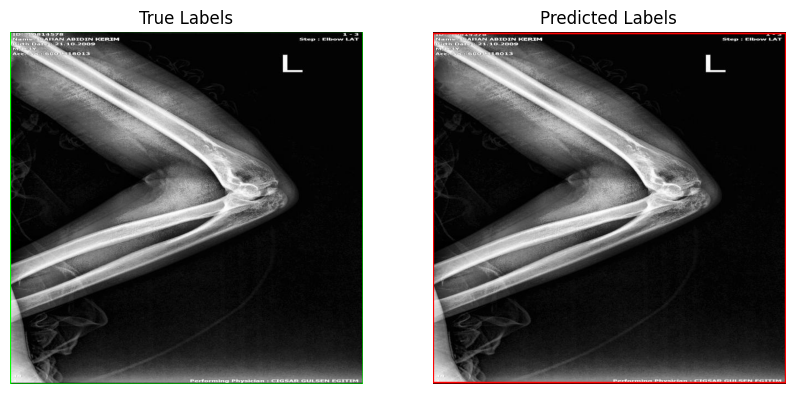


image 1/1 /content/drive/MyDrive/outsource/Bone Fracture/test/images/IMG-0089-00001_jpg.rf.60e176aa1dca75ba147ecbfe04ae3106.jpg: 640x640 1 Not_Fracture, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


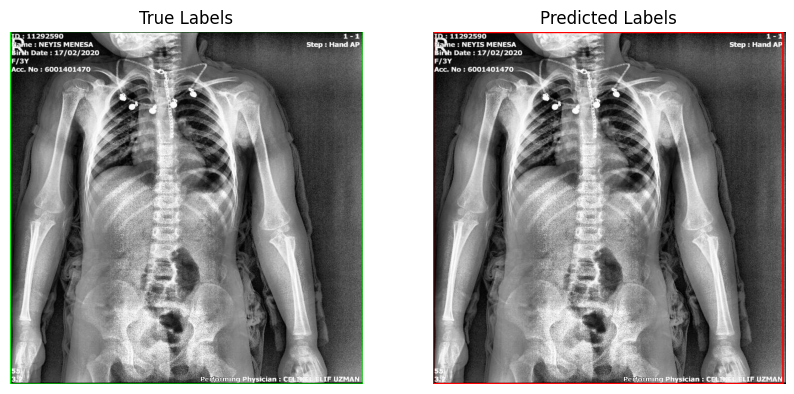


image 1/1 /content/drive/MyDrive/outsource/Bone Fracture/test/images/normal-50-_jpg.rf.6c8f49d5f668295ca43f7a2fef6d36c4.jpg: 640x640 1 Not_Fracture, 9.9ms
Speed: 2.8ms preprocess, 9.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


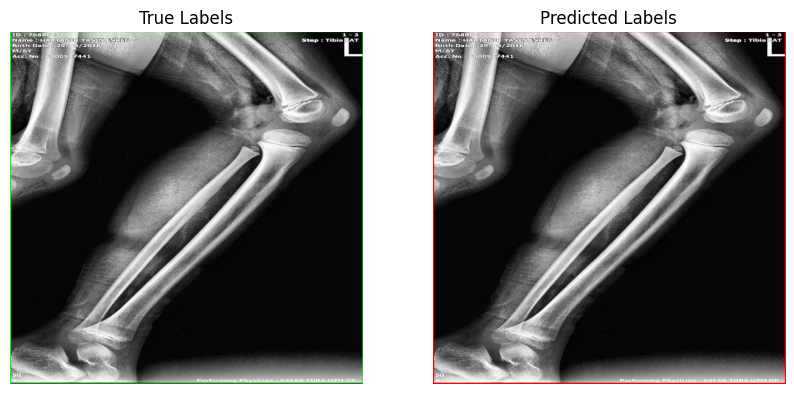


image 1/1 /content/drive/MyDrive/outsource/Bone Fracture/test/images/IMG-0190-00001_jpg.rf.e08c6b1b53b04983201686cdf817133b.jpg: 640x640 1 Not_Fracture, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


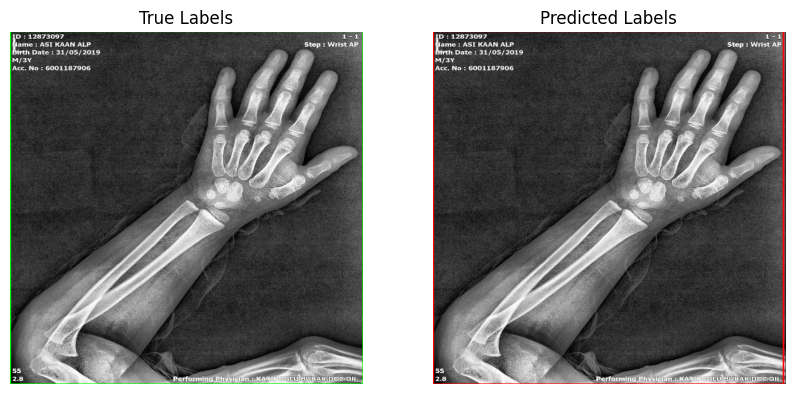


image 1/1 /content/drive/MyDrive/outsource/Bone Fracture/test/images/normal-333-_jpg.rf.4bdad854515381cd898ce63d700b741c.jpg: 640x640 1 Not_Fracture, 9.2ms
Speed: 2.5ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


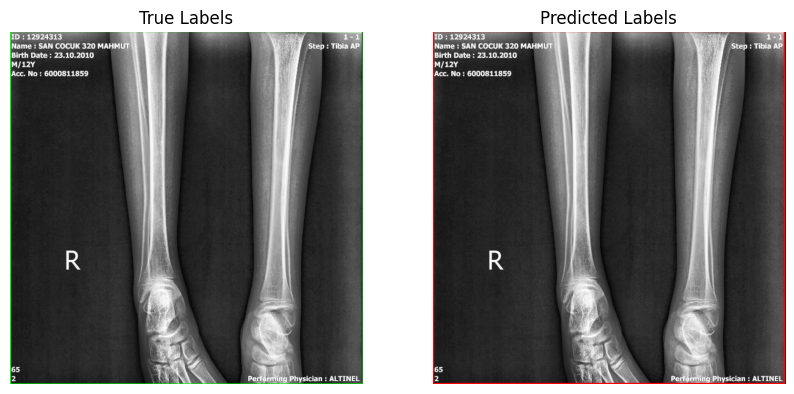


image 1/1 /content/drive/MyDrive/outsource/Bone Fracture/test/images/IMG-0150-00001_jpg.rf.026c64605cc5b842f6b2999a7d35c5cd.jpg: 640x640 1 Not_Fracture, 8.6ms
Speed: 3.1ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)


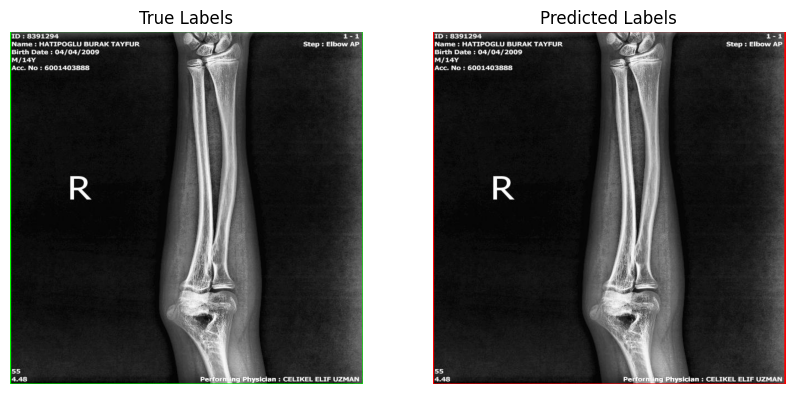


image 1/1 /content/drive/MyDrive/outsource/Bone Fracture/test/images/IMG-0443-00001_jpg.rf.0cd87d89a17dd8f07255a8ed09c302e7.jpg: 640x640 1 Not_Fracture, 13.7ms
Speed: 3.0ms preprocess, 13.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


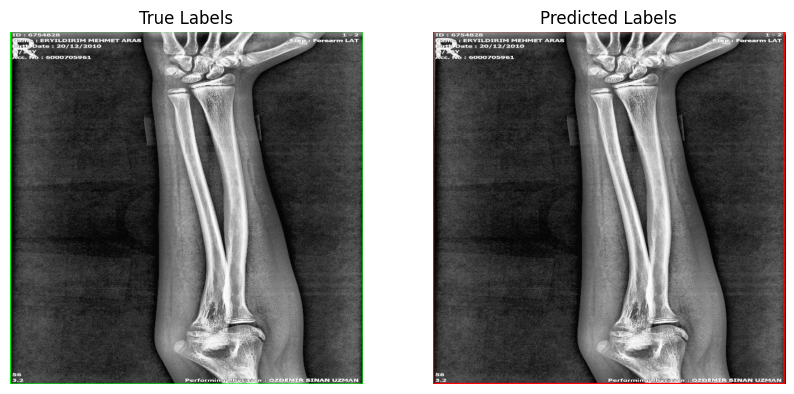


image 1/1 /content/drive/MyDrive/outsource/Bone Fracture/test/images/normal-213-_jpg.rf.c660bbab76a913231cb98a714d9267f2.jpg: 640x640 1 Not_Fracture, 10.3ms
Speed: 4.3ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


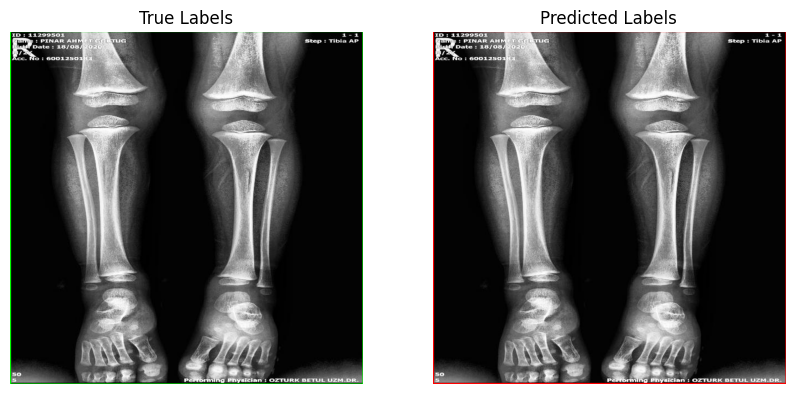


image 1/1 /content/drive/MyDrive/outsource/Bone Fracture/test/images/kirik-113-_jpg.rf.4d0d7668c3b0a0168a8d0283db52b000.jpg: 640x640 1 Not_Fracture, 13.5ms
Speed: 2.3ms preprocess, 13.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


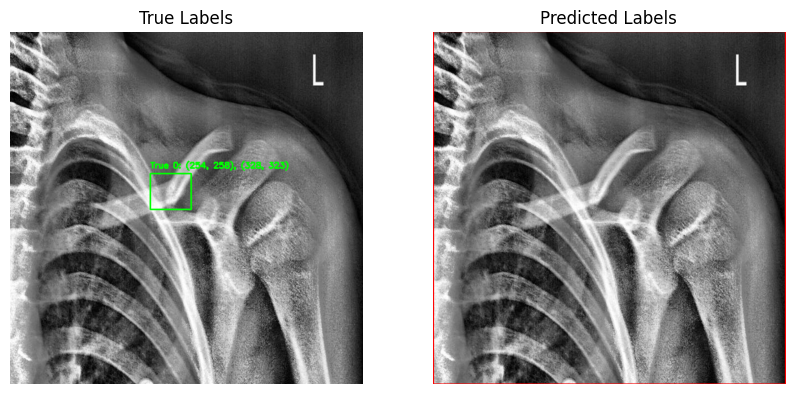


image 1/1 /content/drive/MyDrive/outsource/Bone Fracture/test/images/IMG-0087-00001_jpg.rf.11d3adf9d9da39ebf53d7d020812b9cb.jpg: 640x640 1 Not_Fracture, 12.6ms
Speed: 2.3ms preprocess, 12.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


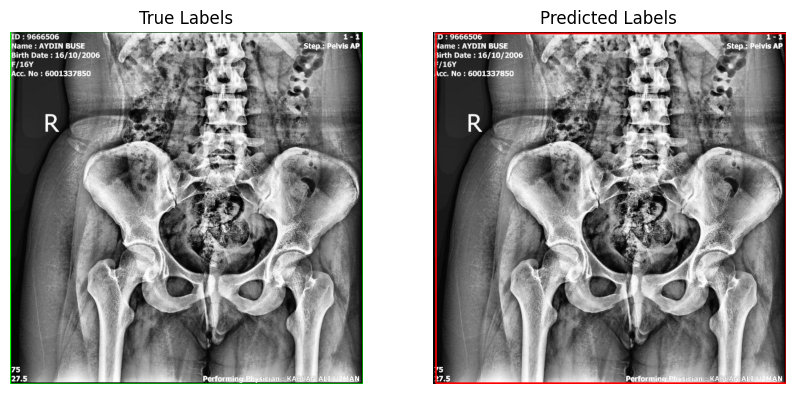

In [ ]:
# Đường dẫn tới thư mục chứa ảnh test và nhãn test
test_image_dir = '/content/drive/MyDrive/outsource/Bone Fracture/test/images'
test_label_dir = '/content/drive/MyDrive/outsource/Bone Fracture/test/labels'


# Lấy danh sách các file ảnh trong tập test
test_image_files = [f for f in os.listdir(test_image_dir) if f.endswith('.jpg') or f.endswith('.png')]

# Chọn ngẫu nhiên 10 ảnh từ tập test
sample_images = random.sample(test_image_files, 10)

# Dự đoán và hiển thị kết quả
for image_file in sample_images:
    # Đọc ảnh
    image_path = os.path.join(test_image_dir, image_file)
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB để hiển thị với matplotlib

    # Đọc nhãn thực tế (true labels)
    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(test_label_dir, label_file)

    true_labels = read_labels(label_path) if os.path.exists(label_path) else []

    # Vẽ nhãn thật cùng tọa độ lên ảnh
    image_with_true_labels = draw_bounding_boxes_with_coords(image_rgb.copy(), true_labels, color=(0, 255, 0), label_type="True")

    # Dự đoán kết quả từ mô hình YOLOv8
    results = model.predict(source=image_path, save=False)
    pred_labels = results[0].boxes.xywhn.cpu().numpy()  # Dự đoán bounding boxes theo định dạng YOLOv8
    pred_classes = results[0].boxes.cls.cpu().numpy()   # Lấy nhãn dự đoán (class)

    pred_labels_with_class = [(int(pred_classes[i]), pred_labels[i]) for i in range(len(pred_classes))]

    # Vẽ nhãn dự đoán lên ảnh
    image_with_predictions = draw_bounding_boxes_with_coords(image_rgb.copy(), pred_labels_with_class, color=(255, 0, 0), label_type="Pred")

    # Hiển thị ảnh với nhãn thật và nhãn dự đoán
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image_with_true_labels)
    plt.title("True Labels")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_with_predictions)
    plt.title("Predicted Labels")
    plt.axis('off')

    plt.show()

# 6. Thử mô hình với ảnh truyền vào

Saving t4.jpg to t4.jpg

image 1/1 /content/t4.jpg: 640x640 4 Fractures, 7.7ms
Speed: 4.2ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


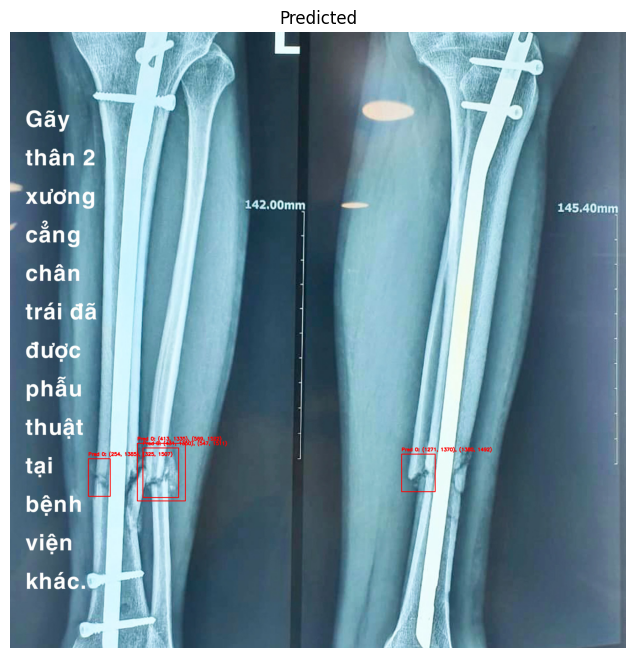

In [7]:
from google.colab import files
import cv2
import matplotlib.pyplot as plt

# Tải ảnh lên
uploaded = files.upload()

# Lấy tên file ảnh
image_filename = next(iter(uploaded))

# Đọc ảnh
image_path = image_filename
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB để hiển thị với matplotlib

# read model
model = YOLO('/content/drive/MyDrive/outsource/Bone Fracture/runs/detect/yolov8_detection3/weights/best.pt')

# Dự đoán kết quả từ mô hình YOLOv8
results = model.predict(source=image_path, save=False)
pred_labels = results[0].boxes.xywhn.cpu().numpy()  # Dự đoán bounding boxes theo định dạng YOLOv8
pred_classes = results[0].boxes.cls.cpu().numpy()   # Lấy nhãn dự đoán (class)

pred_labels_with_class = [(int(pred_classes[i]), pred_labels[i]) for i in range(len(pred_classes))]

# Vẽ nhãn dự đoán lên ảnh
image_with_predictions = draw_bounding_boxes_with_coords(image_rgb.copy(), pred_labels_with_class, color=(255, 0, 0), label_type="Pred")

# Hiển thị ảnh với nhãn dự đoán
plt.figure(figsize=(8, 8))
plt.imshow(image_with_predictions)
plt.title("Predicted")
plt.axis('off')
plt.show()
